In [1]:
# Do for the first run
# ! make install
# ! make download

In [22]:
import copy
import random
import glob
import os
import time
import random

from torchvision.io import read_image
import PIL
from PIL import Image
from dataclasses import dataclass
import matplotlib.pyplot as plt
from collections import Counter
import math
from torchvision.utils import make_grid
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torchvision
from pandas.core.common import flatten
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import models 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import requests
from tqdm.notebook import tqdm
from pathlib import Path

In [23]:
split_pers = 0.8
if torch.backends.mps.is_available():
    DEVICE = "mps" # apple selicon
elif torch.backends.cuda.is_available():
    DEVICE='cuda' # for NVidia GPU 
else:
    DEVICE='cpu' # Other    
print('Device:', DEVICE)
num_epochs = 7
learning_rate = 1e-3
batch_size = 64
shuffle = True
pin_memory = True
num_workers = 0
PRETRAINED = True
NORMALIZE_IMAGES = True
LIMIT_LABELS = 100
model_path = "./data/model.pth"

Device: mps


In [24]:
def resize_images(res: int) -> None:
    """
    Приведение разрешения изображение к res
    """
    root_dir = "data/png/"
    new_dir = "data/png_resized/"
    try:
        os.mkdir(new_dir)
    except OSError:
        pass

    for node in tqdm(sorted(os.listdir(root_dir))):
        if os.path.isfile(root_dir + node):
            continue

        label_path = root_dir + node + "/"
        new_path = new_dir + node + "/"

        try:
            os.mkdir(new_path)
        except OSError:
            pass

        for im_file in os.listdir(label_path):
            im_path = label_path + im_file
            new_im_path = new_path + im_file

            try:
                img = Image.open(im_path)
            except Exception as exc:
                print(f"Not an image {im_path=}, {exc=}")
                continue
            img = img.resize((res, res), PIL.Image.BILINEAR)
            img.save(new_im_path)
            img.close()

# Do for the first run
# resize_images(256)

In [25]:
### Определение и создание датасетов

class PhotoDataset(Dataset):
    def __init__(self):
        self.path = './data/png_resized/'
        with open('./data/png/filelist.txt') as f:
            self.mapping: list[str] = f.read().splitlines()

        self.labels: list[str] = []
        self.labels_unique: set[str] = set()
        count = 0
        for mapping in self.mapping:
            if LIMIT_LABELS != -1 and len(self.labels_unique) >= LIMIT_LABELS:
                break 
                
            label = mapping.split('/')[0]
            self.labels.append(label)
            self.labels_unique.add(label)
            count += 1
            
        self.mapping = self.mapping[:count]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

        self._images: list = []
        print("Loading images")
        for idx in tqdm(range(len(self.mapping))):
            self._images.append(self.get_image_as_np(idx))

        self._image_label_id: list[tuple[Image, str]] = []
        self._image_label: list[tuple[Image, str]] = []
        print("Preprocessing images")
        for idx in tqdm(range(len(self.mapping))):
            label = self.labels[idx]
            image = self._images[idx]
            augmentations = self._augmentate(image)
            
            label_id = self.encode_label(label)


            for augmentation in augmentations:
                self._image_label_id.append((augmentation, label_id))
                self._image_label.append((augmentation, label))
    
    def encode_label(self, label: str) -> str:
        return self.label_encoder.transform([label]).item()

    def decode_label(self, label_id: str) -> str:
        return self.label_encoder.inverse_transform([label_id])[0]
    
    def __len__(self):
        return len(self._image_label_id)

    def __getitem__(self, idx: int) -> tuple[Image, str]:
        return self._image_label_id[idx]

    def get_image_as_np(self, idx: int) -> np.ndarray:
        image = np.array(self.read_image(idx), dtype='float32')[0]
        if NORMALIZE_IMAGES:
            image = np.array(image / 255, dtype='float32')

        out = image
        width, height = image.shape
        out = np.empty((3, width, height), dtype='float32')
        out[0:, :] = image
        out[1:, :] = image
        out[2:, :] = image

        return out

    def _augmentate(self, im: np.ndarray) -> list[np.ndarray]:
        # All rotations
        # [
        #     im.copy(),
        #     np.flip(im, axis=2).copy(),
        #     np.rot90(im, axes=(2, 1)).copy(),
        #     np.rot90(np.flip(im, axis=2), axes=(2, 1)).copy(),
        #     np.rot90(im, k=2, axes=(2, 1)).copy(),
        #     np.rot90(np.flip(im, axis=2), k=2, axes=(2, 1)).copy(),
        #     np.rot90(im, k=3, axes=(2, 1)).copy(),
        #     np.rot90(np.flip(im, axis=2), k=3, axes=(2, 1)).copy(),
        # ]
        
        return [
            im.copy(),
            np.flip(im, axis=2).copy(),
        ]
        
    def read_image(self, idx: int) -> Image:
        im_path = self.path + self.mapping[idx]
        image = read_image(im_path)
        return image
    
    def get_image_and_label(self, idx: int) -> tuple[Image, str]:
        return self._image_label[idx]
    
    def to_list(self) -> list[tuple[Image, str]]:
        return self._image_label


dataset = PhotoDataset()
dataset_list = dataset.to_list()
dataset_len = len(dataset)
dataset_len, len(dataset.labels_unique)

Loading images


  0%|          | 0/7921 [00:00<?, ?it/s]

Preprocessing images


  0%|          | 0/7921 [00:00<?, ?it/s]

(15842, 100)

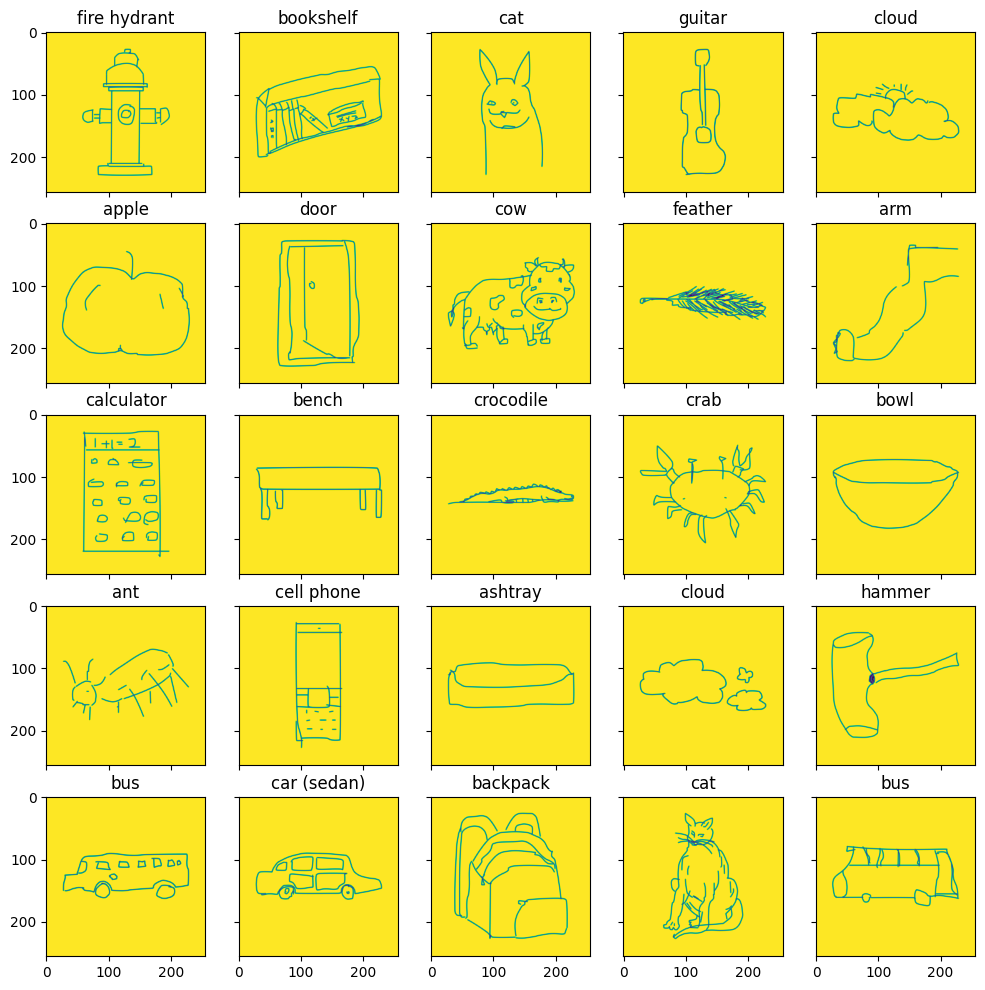

In [26]:
def show_batch(dl: list[tuple[Image, str]], nrows: int, ncols: int):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey=True, sharex=True)
    for idx, fig_x in enumerate(ax.flatten()):
        im, label = dl[idx]
        fig_x.imshow(im[0])
        fig_x.set_title(label)
        

nrows = 5
ncols = 5
show_batch(random.choices(dataset_list, k=nrows*ncols), nrows=nrows, ncols=ncols)

0it [00:00, ?it/s]

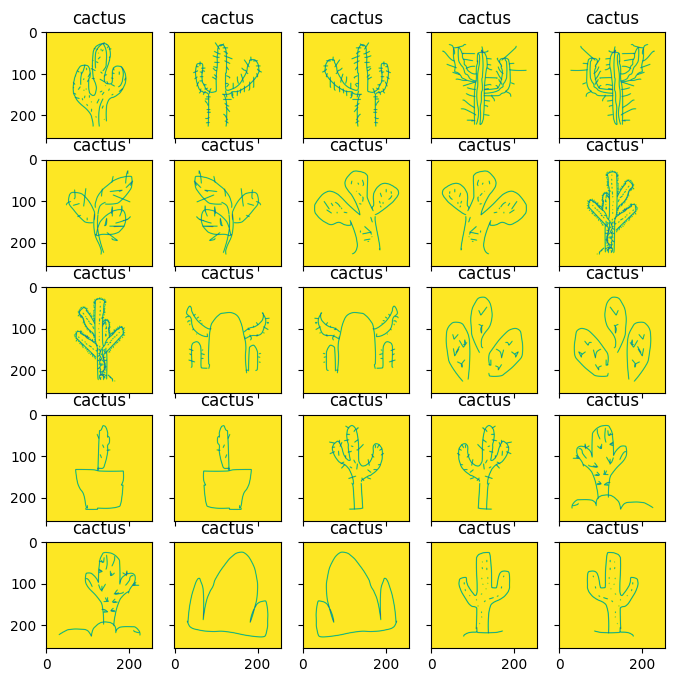

In [27]:
def show_batch(dl: list, nrows: int, ncols: int):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8), sharey=True, sharex=True)
    for idx, fig_x in tqdm(enumerate(ax.flatten())):
        im, label = dl[idx]
        fig_x.imshow(im[0].reshape((256, -1)))
        fig_x.set_title(dataset.decode_label(label))
        

start_idx = np.random.randint(0, len(dataset))
nrows = 5
ncols = 5
# show_batch(random.choices([dataset[0], dataset[3]], k=nrows*ncols), nrows=nrows, ncols=ncols)
show_batch([dataset[idx] for idx in range(start_idx, start_idx+nrows*ncols)], nrows=nrows, ncols=ncols)

In [28]:
train_len = math.ceil(dataset_len * split_pers)
val_len = dataset_len - train_len


train_ds, val_ds = random_split(dataset, (train_len, val_len))
len(train_ds), len(val_ds)

(12674, 3168)

In [29]:
train_ds_counter = Counter((label for _, label in train_ds))
val_ds_counter = Counter((label for _, label in val_ds))

for label in dataset.labels_unique:
    label_id = dataset.label_encoder.transform([label])[0]
    train_label_count = train_ds_counter[label_id]
    val_label_count = val_ds_counter[label_id]
    
    print(f'{label}: {train_label_count} {val_label_count} ({round(train_label_count/(train_label_count+val_label_count)*100, 3)}%)')



computer monitor: 136 24 (85.0%)
bowl: 131 29 (81.875%)
cell phone: 130 30 (81.25%)
comb: 119 41 (74.375%)
cannon: 135 25 (84.375%)
cigarette: 126 34 (78.75%)
cake: 134 26 (83.75%)
baseball bat: 128 32 (80.0%)
crown: 129 31 (80.625%)
frog: 132 28 (82.5%)
bread: 121 39 (75.625%)
airplane: 136 24 (85.0%)
bee: 125 35 (78.125%)
flying bird: 128 32 (80.0%)
blimp: 128 32 (80.0%)
barn: 130 30 (81.25%)
basket: 126 34 (78.75%)
bear (animal): 122 38 (76.25%)
crocodile: 131 29 (81.875%)
fish: 120 40 (75.0%)
hand: 128 32 (80.0%)
candle: 124 36 (77.5%)
carrot: 125 35 (78.125%)
dolphin: 121 39 (75.625%)
floor lamp: 133 27 (83.125%)
cloud: 128 32 (80.0%)
fan: 137 23 (85.625%)
angel: 133 27 (83.125%)
door: 133 27 (83.125%)
elephant: 125 35 (78.125%)
cup: 124 36 (77.5%)
bookshelf: 127 33 (79.375%)
hammer: 128 32 (80.0%)
bottle opener: 136 24 (85.0%)
feather: 139 21 (86.875%)
bicycle: 130 30 (81.25%)
bridge: 130 30 (81.25%)
fire hydrant: 133 27 (83.125%)
car (sedan): 123 37 (76.875%)
computer-mouse: 126

In [30]:
train_loader = DataLoader(dataset=train_ds, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
val_loader = DataLoader(dataset=val_ds, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [31]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=6, kernel_size=3),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.LazyLinear(1024), # 4096
            nn.ReLU(),
            nn.Dropout(0.25),
        )
        self.fc2 = nn.Sequential(
            nn.LazyLinear(2048), # 8192
            nn.ReLU(),
            nn.Dropout(0.25),
        )

        self.out = nn.LazyLinear(n_classes)
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.out(x)
        return logits

In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int, downsample: nn.Sequential | None = None):
        super().__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.LeakyReLU()
                    )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels)
                    )
        self.downsample = downsample
        self.relu = nn.LeakyReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.downsample is not None:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x

In [33]:
class ResNet(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.inplanes = 6
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, self.inplanes, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(self.inplanes),
                        nn.LeakyReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(8, 3, stride = 1)
        self.layer1 = self._make_layer(16, 4, stride = 2)
        self.layer2 = self._make_layer(32, 6, stride = 2)
        self.layer3 = self._make_layer(64, 3, stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        
        self.fc1 = nn.Sequential(
            nn.LazyLinear(512), 
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        self.out = nn.LazyLinear(n_classes)
        
        
    def _make_layer(self, planes: int, nblocks: int, stride: int) -> nn.Sequential:
        downsample: nn.Sequantial | None = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers: list[nn.Sequential] = []
        layers.append(ResidualBlock(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, nblocks):
            layers.append(ResidualBlock(self.inplanes, planes, stride=1))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)

        return x

In [34]:
def get_pretrained_resnet(n_classes: int) -> nn.Module:
    model = models.resnet50(pretrained=True).to(DEVICE)
    for param in model.parameters():
        param.requires_grad = False   

    model.fc = nn.LazyLinear(n_classes)
    
    return model

In [35]:
def fit_epoch(model: nn.Module, train_loader: DataLoader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = nn.LogSoftmax(dim=1)(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [36]:
def eval_epoch(model: nn.Module, val_loader: DataLoader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            outputs = nn.LogSoftmax(dim=1)(outputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [37]:
def train(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, epochs: int):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)
        criterion = nn.NLLLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [38]:
def predict(model: nn.Module, test_loader: DataLoader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [39]:
n_classes = len(dataset.labels_unique)
# model = SimpleCnn(n_classes).to(DEVICE)
# model = ResNet(n_classes).to(DEVICE)
model = get_pretrained_resnet(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(model)

/Users/teadove/projects/ibragimov_p_i/6-OpenCV-Sadekov-CourceWork/src/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/teadove/projects/ibragimov_p_i/6-OpenCV-Sadekov-CourceWork/src/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


we will classify :100
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_si

/Users/teadove/projects/ibragimov_p_i/6-OpenCV-Sadekov-CourceWork/src/.venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [40]:
# Запуск обучения
history = train(train_loader, val_loader, model=model, epochs=num_epochs)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

loss 2.932914550134732

Epoch 001 train_loss: 2.9329     val_loss 2.0576 train_acc 0.3835 val_acc 0.5354


  0%|          | 0/199 [00:00<?, ?it/s]

loss 1.7003241237620366

Epoch 002 train_loss: 1.7003     val_loss 1.7700 train_acc 0.6311 val_acc 0.5915


  0%|          | 0/199 [00:00<?, ?it/s]

loss 1.4626906597738445

Epoch 003 train_loss: 1.4627     val_loss 1.6544 train_acc 0.6819 val_acc 0.6146


  0%|          | 0/199 [00:00<?, ?it/s]

loss 1.3715247602817933

Epoch 004 train_loss: 1.3715     val_loss 1.6087 train_acc 0.7069 val_acc 0.6143


  0%|          | 0/199 [00:00<?, ?it/s]

loss 1.3497274492335127

Epoch 005 train_loss: 1.3497     val_loss 1.5988 train_acc 0.7055 val_acc 0.6228


  0%|          | 0/199 [00:00<?, ?it/s]

loss 1.3078669217062877

Epoch 006 train_loss: 1.3079     val_loss 1.5394 train_acc 0.7215 val_acc 0.6465


  0%|          | 0/199 [00:00<?, ?it/s]

loss 1.2927141921159426

Epoch 007 train_loss: 1.2927     val_loss 1.5883 train_acc 0.7216 val_acc 0.6323


In [ ]:
def draw_loss_acc(history):
    train_loss, train_acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(4, 4))
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

    plt.figure(figsize=(4, 4))
    plt.plot(train_acc, label="train_acc")
    plt.plot([tensor.cpu() for tensor in val_acc], label="val_acc")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.show()

draw_loss_acc(history)

In [ ]:
# Save
torch.save(model, model_path)

In [65]:
# Load
# model = get_pretrained_resnet(n_classes).to(DEVICE)
model = torch.load(model_path)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [99]:
model.forward(list(val_loader)[0][0].to(DEVICE))

tensor([[ -3.1750,  -0.5342,  -1.8073,  ...,  -3.1979,   3.5876,  -5.6204],
        [ -2.6099,  -0.8148,   1.1751,  ...,   0.8791,   1.1853,  -2.5341],
        [  2.0722,  -2.6621,  -0.2919,  ...,  -0.4434,   0.4153,  -1.3133],
        ...,
        [ -0.2307,   3.7082,  -2.2832,  ...,   1.1736,   4.4365,  -2.5050],
        [-16.9097,  13.6743,  10.7548,  ..., -11.6688,   0.1893, -11.4268],
        [  0.8079,  -1.1891,  -3.3806,  ...,  -3.8167,   1.0194,  -3.7719]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [100]:
_vals = list(val_ds)
def random_images(n: int = 10) -> list[tuple[Image, str]]:
    return random.choices(_vals, k = n)

random_images(n=1)

[(array([[[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          ...,
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
  
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          ...,
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
  
         [[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          ...,
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32),
  184)]

In [101]:
@dataclass
class Prediction:
    real: str 
    predicted: str 
    conf: float
    img: np.ndarray

def predict(model: nn.Module, inputs: list[tuple[Image, str]]) -> list[Prediction]:
    """Предсказание, для одной картинки"""
    results = []
    for input in inputs:
        with torch.no_grad():
            array = np.array([input[0].tolist()], dtype=input[0].dtype)
            logit = model.forward(torch.from_numpy(array).to(DEVICE)).cpu().numpy()
            # prob = torch.nn.functional.softmax(logit, dim=-1).numpy()

            prediction = Prediction(
                real=dataset.decode_label(input[1]), 
                predicted=dataset.decode_label(np.argmax(logit)), 
                conf=np.max(logit),
                img=input[0],    
            )
    
            results.append(prediction)
    return results

predict(model, random_images(n=1))

[Prediction(real='cow', predicted='dog', conf=14.338219, img=array([[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32))]

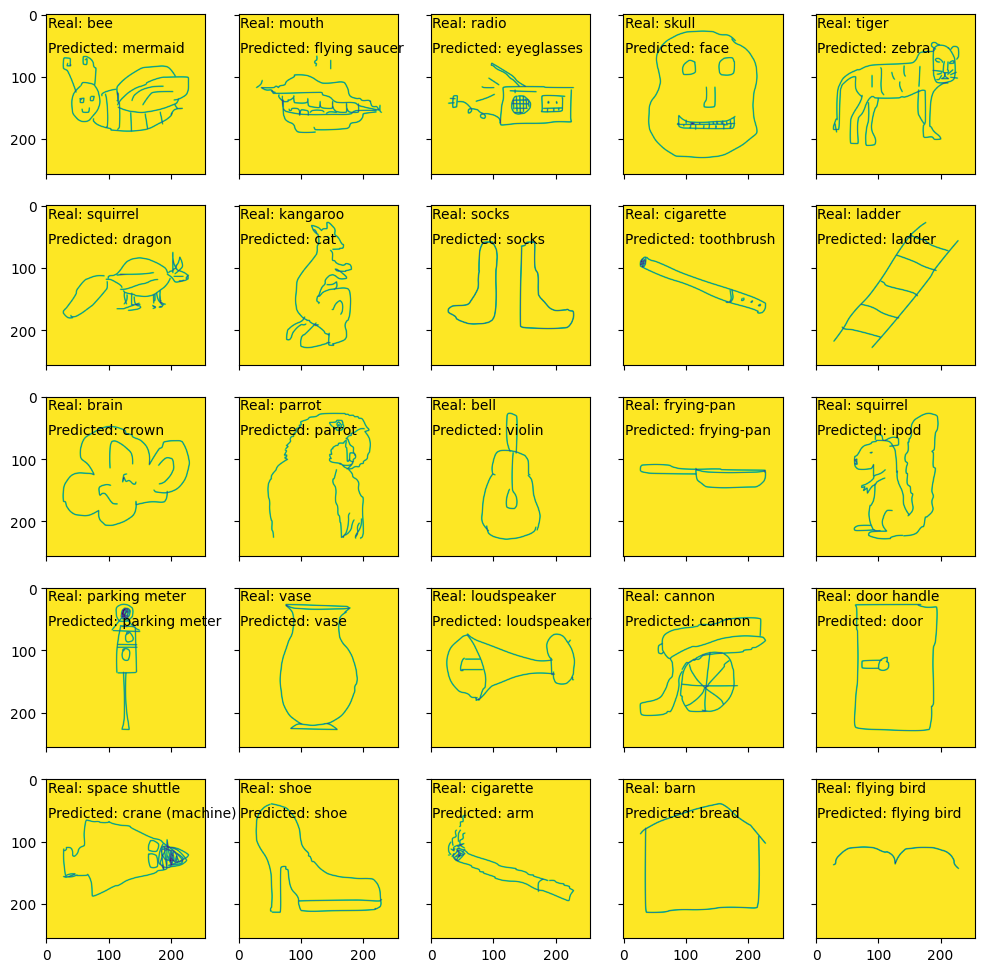

In [102]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties


nrows = 5
ncols = 5
images = random_images(ncols*nrows)
predictions = predict(model, images)

fig, ax = plt.subplots(nrows=ncols, ncols=nrows,figsize=(12, 12), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    img, real_label, predicted_label = predictions[i].img, predictions[i].real, predictions[i].predicted
    
    fig_x.imshow(img[0].reshape((256, -1)))
    
    fig_x.text(2, 20, "Real: {}".format(real_label))
    fig_x.text(2, 60, "Predicted: {}".format(predicted_label))